# Quantification des couleurs d'une image avec k-means

Inspiré de https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

In [34]:
# Initialisations
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (w, h)
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from sklearn.datasets import load_sample_image
import imageio
from time import time


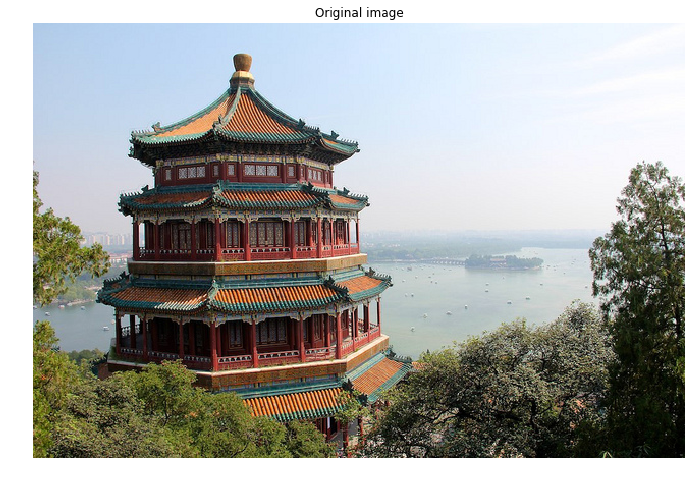

In [35]:
# Chargement de l'image à traiter

# china = load_sample_image("china.jpg") # deprecated

china = imageio.imread( 'china.jpg')

# Display all results, alongside original image
plt.axis('off')
plt.title('Original image')
plt.imshow(china)
plt.show()

In [3]:
# Comment est représentée l'image ?
print(type(china))
print(china.shape)
print(china[0,10]) # le dixième pixel de la ligne 0

<class 'imageio.core.util.Array'>
(427, 640, 3)
[172 201 231]


Chaque pixel est un vecteur `(r, g, b)`

L'image est donc un tableau `hauteur x largeur x 3`

In [13]:
# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
img = np.array(china, dtype=np.float64) / 255

w, h, d = china.shape
assert d == 3 # ne traite que les image couleur RGB
image_array = img.reshape(w * h, d) # un tableau des pixels, sans structure 2D
print(image_array.shape)

(273280, 3)


In [14]:
# Combien de couleurs distinctes ?
# Exemple d'utilisation de la fonction unique:
A = np.array( [ (0,0,0), (1,1,1), (1,2,3), (0,0,0)])
print(A)
print('Unique: \n', np.unique(A, axis=0))

[[0 0 0]
 [1 1 1]
 [1 2 3]
 [0 0 0]]
Unique: 
 [[0 0 0]
 [1 1 1]
 [1 2 3]]


In [15]:
print( 'Il y a', len( np.unique(image_array, axis=0)), 'couleurs distinctes sur', w*h, 'pixels' )

Il y a 96615 couleurs distinctes sur 273280 pixels


# Quantification
La fonction `pairwise_distances_argmin` https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html#sklearn.metrics.pairwise_distances_argmin
calcule les indices des points les plus proches


In [16]:
# prenons N couleurs au hasard (on choisi N pixels aléatoires de l'image):
n_colors = 16 # N
codebook_random = shuffle(image_array, random_state=0)[:n_colors]

# Applique ce codeur à l'image:
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("done in %0.3fs." % (time() - t0))


done in 0.060s.


(-0.5, 639.5, 426.5, -0.5)

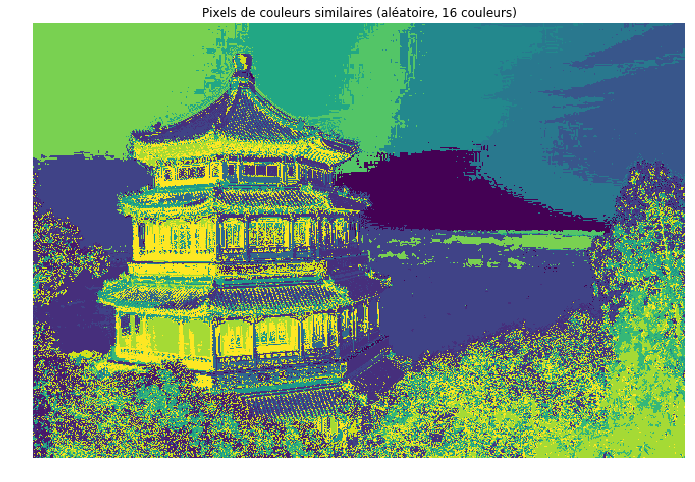

In [44]:
plt.imshow(labels_random.reshape(w, h))
plt.title('Pixels de couleurs similaires (aléatoire, %d couleurs)' % n_colors)
plt.axis('off')

In [17]:
# Fonction recréant une image à partir des étiquettes du codebook
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


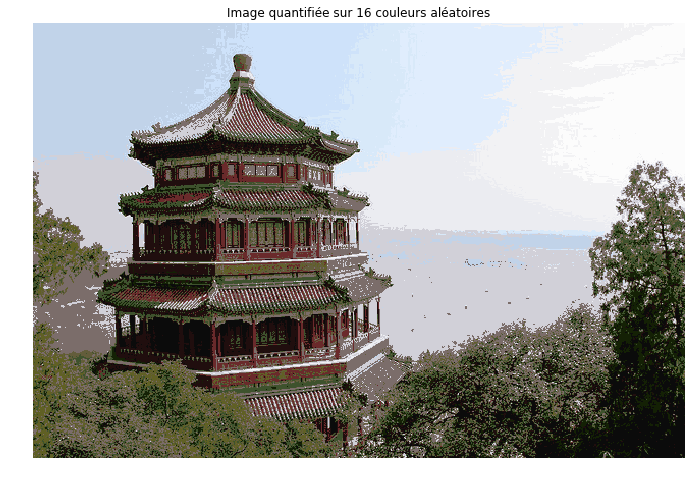

In [24]:
# Construit image quantifiée
img_q_random = recreate_image(codebook_random, labels_random, w, h)
# Affiche le résultat
plt.axis('off')
plt.title('Image quantifiée sur %d couleurs aléatoires' % n_colors)
plt.imshow(img_q_random)
plt.show()

# Quantification avec k-means

In [22]:
print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

Fitting model on a small sub-sample of the data
done in 0.111s.


In [25]:
# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels_kmeans = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))

Predicting color indices on the full image (k-means)
done in 0.070s.


(-0.5, 639.5, 426.5, -0.5)

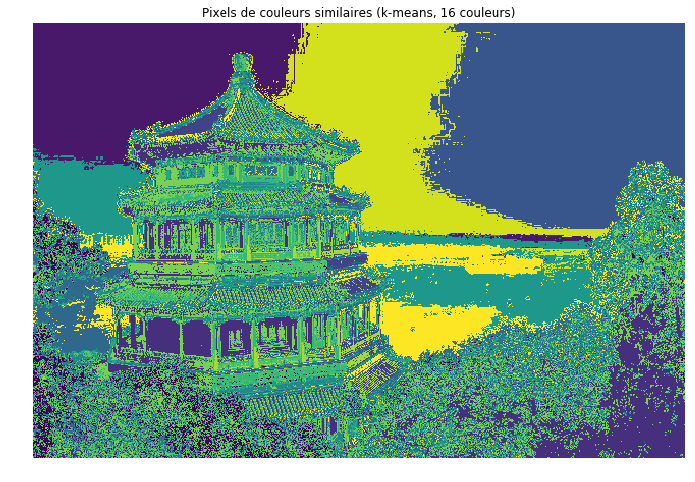

In [46]:
plt.imshow(labels_kmeans.reshape(w, h))
plt.title('Pixels de couleurs similaires (k-means, %d couleurs)' % n_colors)
plt.axis('off')

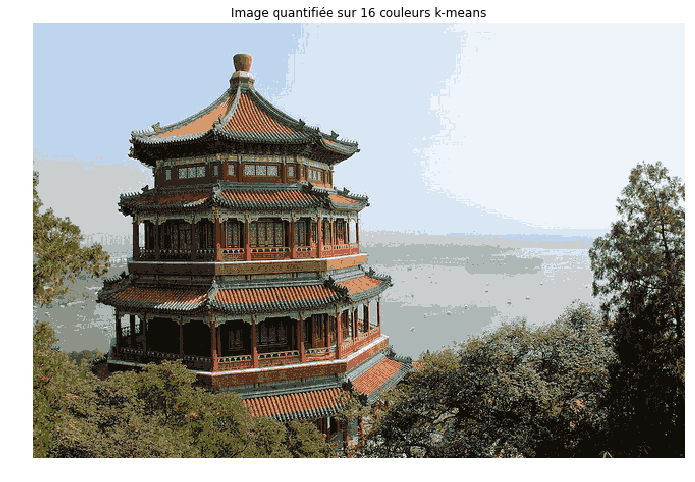

In [26]:
# Construit image quantifiée
img_q_kmeans = recreate_image(kmeans.cluster_centers_, labels_kmeans, w, h)
# Affiche le résultat
plt.axis('off')
plt.title('Image quantifiée sur %d couleurs k-means' % n_colors)
plt.imshow(img_q_kmeans)
plt.show()

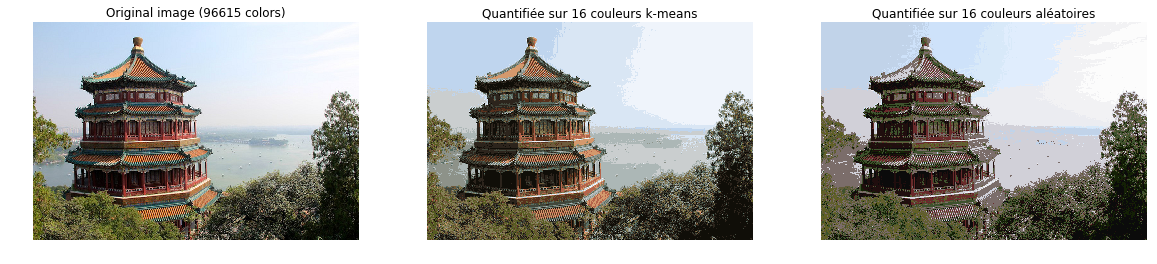

In [39]:
# Affichage des trois images côte à côte
plt.figure(figsize=(20,4))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Original image (96615 colors)')
plt.imshow(china)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Quantifiée sur %d couleurs k-means' % n_colors)
plt.imshow(recreate_image(kmeans.cluster_centers_, labels_kmeans, w, h))

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Quantifiée sur %d couleurs aléatoires' % n_colors)
plt.imshow(recreate_image(codebook_random, labels_random, w, h))

plt.savefig('kms-couleurs.pdf')
plt.show()